# RNN text classification

In this notebook, we'll go through a straightforward application of recurrent neural networks to binary text classification in Keras.

## Load IMDB data

This is the same data as in [the BoW classifier notebook](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/bow_classifier.ipynb).

(Note that there is direct support for IMDB in keras (`keras.datasets.imdb`). We're doing the preprocessing explicitly here to show all the steps.)

First, download the dataset.

In [24]:
# Give -nc (--no-clobber) argument so that the file isn't downloaded multiple times 
!wget -nc https://raw.githubusercontent.com/TurkuNLP/Deep_Learning_in_LangTech_course/master/data/imdb_train.json

File ‘imdb_train.json’ already there; not retrieving.



Next, we'll load the JSON-formatted data. This gives us a list of dictionaries, each of which has `class` and `text`.

In [2]:
import json


with open('imdb_train.json') as f:
    data = json.load(f)
    

# Look at the data
print(type(data))
print(type(data[0]))
print(data[0].keys())
print(data[0])

<class 'list'>
<class 'dict'>
dict_keys(['class', 'text'])
{'class': 'pos', 'text': "With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.  Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is real

Let's be careful and shuffle our data first, and then separate the texts and labels for further processing.

In [3]:
import random
import numpy as np

    
random.seed(1234)    # This makes the shuffle produce the same order every time
random.shuffle(data)

texts = [example['text'] for example in data]
labels = [example['class'] for example in data]

# Example text and label
print('Text:', texts[0])
print('Label:', labels[0])

Text: I saw Insomniac's Nightmare not to long ago for the first time and I have to say, I really found it to be quite good. If you are a fan of Dominic Monaghan you will love it. The hole movie takes place inside his mind -or does it? The acting from everyone else is a little rushed and shaky and some of the scenes could be cut down but it works out in the end. The extras on the DVD are just as great as the film, if not greater for those Dom fans. It has tons of candid moments from the set, outtakes and a great interview with the director. Anyone who has gone through making an independent film will love to watch Tess (the director), Dom and everyone else on the very small close personal set try to bang out this little trippy creepy film. It was pretty enjoyable and I'm glad to have it in my collection.
Label: pos


## Preprocess data

Both the text and the labels are strings; we'll need to convert the labels into integers and the text into an appropriate format for RNN training.

### Labels

For the labels, we'll use the simple sklearn [`LabelEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html), as before.

In [4]:
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()    # Turns class labels into integers
Y = label_encoder.fit_transform(labels)

# See how those compare
print(type(labels), labels[:10])
print(type(Y), Y[:10])

<class 'list'> ['pos', 'neg', 'pos', 'pos', 'pos', 'neg', 'neg', 'pos', 'neg', 'pos']
<class 'numpy.ndarray'> [1 0 1 1 1 0 0 1 0 1]


### Texts

We'll then use a keras [`Tokenizer`](https://keras.io/preprocessing/text/) to vectorize the texts.

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer


# Excepting for num_words, the values below are the defaults for Tokenizer parameters.
# They are included here explicitly to show some of the options for using Tokenizer.

tokenizer = Tokenizer(
    num_words=100000,
    lower=True,
    split=' ',
    char_level=False
)

tokenizer.fit_on_texts(texts)

`tokenizer.fit_on_texts()` creates a mapping from tokens to integers.

Note: that the value 0 is not used in the mapping. This allows us to use it for padding. (There isn't anything magical about 0, this is just convention.)

In [6]:
from pprint import pprint    # pretty-printer


def truncate_dict(d, count=10):
    # Returns at most count items from the given dictionary.  
    return dict(i for i, _ in zip(d.items(), range(count)))


# Check if 0 is in the index, and print examples of the mapping
print(tokenizer.word_index.get(0))
pprint(truncate_dict(tokenizer.word_index))

None
{'a': 3,
 'and': 2,
 'i': 9,
 'in': 7,
 'is': 6,
 'it': 8,
 'of': 4,
 'the': 1,
 'this': 10,
 'to': 5}


After initializing the token string to integer mapping, we use `texts_to_sequences` to convert each text to a corresponding sequence of integers.

In [7]:
sequences = tokenizer.texts_to_sequences(texts)

# Print an example text, its corresponding sequence, and the tokens it represents
print('Text:', texts[0][:100])
print('Sequence:', sequences[0])
print('Mapped back:', [tokenizer.index_word[i] for i in sequences[0][:10]])

Text: I saw Insomniac's Nightmare not to long ago for the first time and I have to say, I really found it 
Sequence: [9, 215, 20597, 1719, 20, 5, 192, 592, 14, 1, 82, 54, 2, 9, 24, 5, 131, 9, 62, 254, 8, 5, 26, 175, 48, 43, 21, 22, 3, 333, 4, 7261, 13419, 21, 76, 115, 8, 1, 2931, 16, 300, 269, 1000, 23, 326, 38, 123, 8, 1, 112, 35, 312, 330, 6, 3, 113, 3308, 2, 5073, 2, 45, 4, 1, 135, 96, 26, 601, 176, 17, 8, 491, 42, 7, 1, 126, 1, 2252, 19, 1, 284, 22, 39, 13, 83, 13, 1, 18, 43, 20, 2780, 14, 144, 8057, 447, 8, 44, 3395, 4, 14895, 384, 35, 1, 266, 13420, 2, 3, 83, 2695, 15, 1, 163, 255, 33, 44, 820, 139, 227, 31, 1720, 18, 76, 115, 5, 102, 8058, 1, 163, 8057, 2, 312, 330, 19, 1, 51, 388, 487, 961, 266, 349, 5, 4009, 42, 10, 113, 12257, 943, 18, 8, 12, 180, 733, 2, 142, 1259, 5, 24, 8, 7, 57, 1587]
Mapped back: ['i', 'saw', "insomniac's", 'nightmare', 'not', 'to', 'long', 'ago', 'for', 'the']


Note that these sequences are variable length:

In [8]:
lengths = [len(s) for s in sequences]
print('Lengths:', lengths[:10], 'min:', min(lengths), 'max:', max(lengths), 'mean:', np.mean(lengths))

Lengths: [160, 217, 182, 270, 252, 220, 335, 117, 172, 283] min: 10 max: 2473 mean: 233.63884


### Pad and truncate sequences

RNNs can process variable-length inputs. However, RNN implementations can have their own constraints.

Keras expects all examples in a batch to be the same length. To make it possible to train with batch sizes larger than one, we use [`pad_sequences`](https://keras.io/preprocessing/sequence/#pad_sequences) to pad and truncate all sequences to a fixed length.

(An alternative approach is to use `batch_size=1` when training)

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


# The padding and truncating parameters default to 'pre', i.e. aligning
# the end of the input with the end of the padded sequence. With 'post',
# we're here aligning the beginning instead.

post_padded_X = pad_sequences(
    sequences,
    maxlen=250,
    padding='post',
    truncating='post',
    value=0
)

# Compare those
print('type(sequences):', type(sequences))
print('type(padded):', type(post_padded_X))
print('padded.shape:', post_padded_X.shape)

type(sequences): <class 'list'>
type(padded): <class 'numpy.ndarray'>
padded.shape: (25000, 250)


**This is the representation of the data that our model will see.**

As in the case of the bag-of-words MLP example, we have produced a matrix of shape `(num_examples, n)`.

However, these are quite different: in the bag-of-words representation `n` was the size of the vocabulary and each row consisted of indicator values (0 or 1) signaling the presence or absence of a word in a document. Here `n` is the (padded) sequence length, and the values are the indices of vocabulary items.

In [10]:
print('Post-padded:')
print(post_padded_X[0])
print('Mapped back:', [tokenizer.index_word[i] for i in post_padded_X[0][:10]])

Post-padded:
[    9   215 20597  1719    20     5   192   592    14     1    82    54
     2     9    24     5   131     9    62   254     8     5    26   175
    48    43    21    22     3   333     4  7261 13419    21    76   115
     8     1  2931    16   300   269  1000    23   326    38   123     8
     1   112    35   312   330     6     3   113  3308     2  5073     2
    45     4     1   135    96    26   601   176    17     8   491    42
     7     1   126     1  2252    19     1   284    22    39    13    83
    13     1    18    43    20  2780    14   144  8057   447     8    44
  3395     4 14895   384    35     1   266 13420     2     3    83  2695
    15     1   163   255    33    44   820   139   227    31  1720    18
    76   115     5   102  8058     1   163  8057     2   312   330    19
     1    51   388   487   961   266   349     5  4009    42    10   113
 12257   943    18     8    12   180   733     2   142  1259     5    24
     8     7    57  1587     0     0  

## Build model

We define a basic RNN model that takes the RNN cell class (`RNN_class`) as an argument:

* input: sequence of `sequence_length` integers corresponding to words
* embedding: randomly initialized mapping to `embedding_dim`-dimensional vectors
* rnn: recurrent neural network with `rnn_units`-dimensional state
* output: `num_classes`-dimensional fully connected layer with softmax activation

We're intentionally leaving out a few fairly obvious things that would be expected to help here, including

* Any form of regularization, e.g. dropout
* Initializing the embeddings with pre-trained word vectors
* Masking to ignore padding (see [Masking and padding with Keras](https://www.tensorflow.org/guide/keras/masking_and_padding))

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, LSTM, Dense


def build_rnn_model(RNN_class, sequence_length, vocab_size, num_classes,
                    embedding_dim=250, rnn_units=50):
    input_ = Input(shape=(sequence_length,))
    embedding = Embedding(vocab_size, embedding_dim)(input_)
    # return_sequences=False is the default
    rnn = RNN_class(rnn_units, return_sequences=False)(embedding)
    output = Dense(num_classes, activation='softmax')(rnn)
    return Model(inputs=[input_], outputs=[output])


sequence_length = post_padded_X.shape[1]
vocab_size = tokenizer.num_words
num_classes = len(label_encoder.classes_)

# We'll use the defaults for embedding_dim and rnn_units in all of our examples here.
simple_rnn_model = build_rnn_model(SimpleRNN, sequence_length, vocab_size, num_classes)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [12]:
simple_rnn_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 250, 250)          25000000  
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 50)                15050     
_________________________________________________________________
dense (Dense)                (None, 2)                 102       
Total params: 25,015,152
Trainable params: 25,015,152
Non-trainable params: 0
_________________________________________________________________


## Train simple RNN

We'll then compile and train our model.

Note that as our outputs `Y` are integers (rather than one-hot class indicators), we need to use `sparse_categorical_crossentropy` (instead of `categorical_crossentropy`).

In [13]:
simple_rnn_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [14]:
# We'll use these parameters for training in these examples
epochs = 3
batch_size = 16

simple_rnn_history = simple_rnn_model.fit(
    post_padded_X,
    Y,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1
)

Train on 22500 samples, validate on 2500 samples
Epoch 1/3
22500/22500 [==============================] - 629s 28ms/sample - loss: 0.6986 - acc: 0.5019 - val_loss: 0.6949 - val_acc: 0.5032
Epoch 2/3
22500/22500 [==============================] - 749s 33ms/sample - loss: 0.6494 - acc: 0.5784 - val_loss: 0.7135 - val_acc: 0.4916
Epoch 3/3
22500/22500 [==============================] - 761s 34ms/sample - loss: 0.6409 - acc: 0.5839 - val_loss: 0.7159 - val_acc: 0.5076


Let's plot the training and validation set accuracies.

History: [0.5032, 0.4916, 0.5076]
Max accuracy: 0.5076


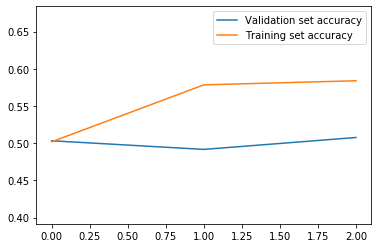

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt


def plot_history(history):
    train_metric = 'acc' if 'acc' in history.history else 'accuracy'
    val_metric = 'val_acc' if 'val_acc' in history.history else 'val_accuracy'
    print("History:", history.history[val_metric])
    print("Max accuracy:", max(history.history[val_metric]))
    y_min = min(history.history[train_metric] + history.history[val_metric])
    y_max = max(history.history[train_metric] + history.history[val_metric])
    plt.ylim(max(y_min-0.1, 0.0), min(y_max+0.1, 1.0))
    plt.plot(history.history[val_metric],label="Validation set accuracy")
    plt.plot(history.history[train_metric],label="Training set accuracy")
    plt.legend()
    plt.show()


plot_history(simple_rnn_history)

Well, that's not learning much of anything.

(What's going on here?)

In [16]:
print('Post-padded:')
print(post_padded_X[0])

Post-padded:
[    9   215 20597  1719    20     5   192   592    14     1    82    54
     2     9    24     5   131     9    62   254     8     5    26   175
    48    43    21    22     3   333     4  7261 13419    21    76   115
     8     1  2931    16   300   269  1000    23   326    38   123     8
     1   112    35   312   330     6     3   113  3308     2  5073     2
    45     4     1   135    96    26   601   176    17     8   491    42
     7     1   126     1  2252    19     1   284    22    39    13    83
    13     1    18    43    20  2780    14   144  8057   447     8    44
  3395     4 14895   384    35     1   266 13420     2     3    83  2695
    15     1   163   255    33    44   820   139   227    31  1720    18
    76   115     5   102  8058     1   163  8057     2   312   330    19
     1    51   388   487   961   266   349     5  4009    42    10   113
 12257   943    18     8    12   180   733     2   142  1259     5    24
     8     7    57  1587     0     0  

`SimpleRNN` implements the basic RNN cell structure introduced as "vanilla RNN" on the lectures. What we're seeing here are the training difficulties we discussed.

## Train LSTM

Let's try the exact same process, except with `LSTM` instead of `SimpleRNN`.

In [17]:
lstm_model = build_rnn_model(LSTM, sequence_length, vocab_size, num_classes)

lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

lstm_history = lstm_model.fit(post_padded_X, Y, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 22500 samples, validate on 2500 samples
Epoch 1/3
22500/22500 [==============================] - 1166s 52ms/sample - loss: 0.6809 - acc: 0.5485 - val_loss: 0.6594 - val_acc: 0.5840
Epoch 2/3
22500/22500 [==============================] - 1218s 54ms/sample - loss: 0.5343 - acc: 0.7284 - val_loss: 0.4214 - val_acc: 0.8268
Epoch 3/3
22500/22500 [==============================] - 1119s 50ms/sample - loss: 0.2925 - acc: 0.8892 - val_loss: 0.3678 - val_acc: 0.8584


History: [0.584, 0.8268, 0.8584]
Max accuracy: 0.8584


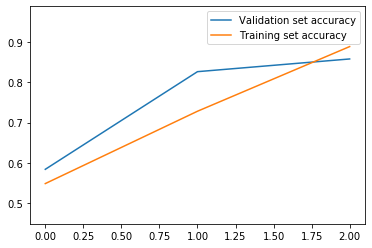

In [22]:
plot_history(lstm_history)

Now we're getting somewhere! (But still not very far.)

Recall that when generating the data, we applied `padding='post'`. Let's see if that made a difference.

In [19]:
pre_padded_X = pad_sequences(
    sequences,
    maxlen=250,
    padding='pre',
    truncating='pre',
    value=0
)

print('Pre-padded:')
print(pre_padded_X[0])

Pre-padded:
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     9   215 20597  1719    20     5
   192   592    14     1    82    54     2     9    24     5   131     9
    62   254     8     5    26   175    48    43    21    22     3   333
     4  7261 13419    21    76   115     8     1  2931    16   300   269
  1000    23   326    38   123     8     1   112    35   312   330     6
     3   113  3308     2  5073     2    45     4     1   135    96    26
   601   176    17     8   491    42   

The real (non-pad) tokens are now aligned with the end of the sequence, leaving less distance from the useful part of the input to the point where the model sees the label.

(Note that this is effectively what [masking](https://www.tensorflow.org/guide/keras/masking_and_padding) would do here.)

In [20]:
model = build_rnn_model(LSTM, sequence_length, vocab_size, num_classes)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

lstm_history_pre = model.fit(pre_padded_X, Y, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/3
22500/22500 [==============================] - 1101s 49ms/sample - loss: 0.4533 - acc: 0.7888 - val_loss: 0.3423 - val_acc: 0.8612
Epoch 2/3
22500/22500 [==============================] - 1330s 59ms/sample - loss: 0.2108 - acc: 0.9196 - val_loss: 0.3435 - val_acc: 0.8692
Epoch 3/3
22500/22500 [==============================] - 1011s 45ms/sample - loss: 0.0950 - acc: 0.9654 - val_loss: 0.4258 - val_acc: 0.8248


History: [0.8612, 0.8692, 0.8248]
Max accuracy: 0.8692


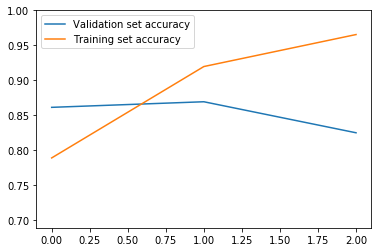

In [23]:
plot_history(lstm_history_pre)

That definitely helps the model learn faster, although performance still isn't amazing. A few takeaways: 1) LSTMs alleviate the challenges with training recurrent models, but don't entirely solve them, and 2) RNNs are not a silver bullet, and won't necessarily outperform other models such as CNNs.

(Those things said, there are certainly many things that we could do to improve this model.)

## Summary

* Evaluated vanilla RNN and LSTM models for binary text classification using the IMDB dataset
* Observed failure of vanilla RNN to learn the task. [RNN training is difficult](http://proceedings.mlr.press/v28/pascanu13.pdf); vanishing/exploding gradients
* Observed that replacing `SimpleRNN` with `LSTM` allowed the network to learn; LSTMs alleviate the training difficulties seen with vanilla RNNs.